In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *

import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,EarlyStopping 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Подлкючаем модуль TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# красивый Progress_board
from tqdm import tqdm_notebook

import time

from sklearn.preprocessing import MinMaxScaler

In [139]:
# была измененен кодек т.к. через utf-8 выдавалась ошибка 

path = 'C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания/'

s = pd.read_csv(path + '4056_Nd данные для обучения.csv', squeeze=True, encoding = "ISO-8859-1" )

v_d = pd.read_csv(path + '4056_Nd_входящие данные дневные.csv', squeeze=True, encoding = "ISO-8859-1" )

v_n = pd.read_csv(path + '4056_Nd_входящие данные ночные.csv', squeeze=True, encoding = "ISO-8859-1" )

In [140]:
print(s.columns)
print(v_d.columns)
print(v_n.columns)

s_value  = s['Value|Ìàêñèìóì'].values
vd_value = v_d['Value'].values
vn_value = v_n['Value'].values

print(s_value.shape)
print(vd_value.shape)
print(vn_value.shape)

Index(['TimeValue', 'Value|Ìàêñèìóì'], dtype='object')
Index(['TimeValue', 'Value'], dtype='object')
Index(['TimeValue', 'Value'], dtype='object')
(896770,)
(1349,)
(1402,)


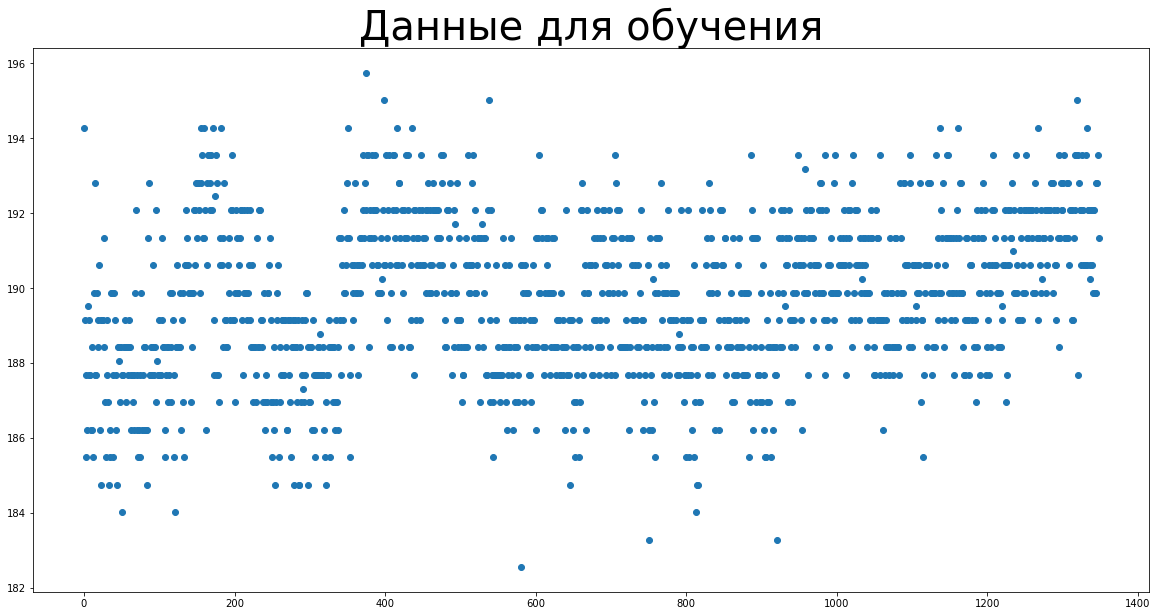

In [143]:
plt.figure(figsize=(20,10))
plt.title('Данные для обучения', fontsize=40)
plt.scatter(x=range(1349), y=s_value[:1349]) 

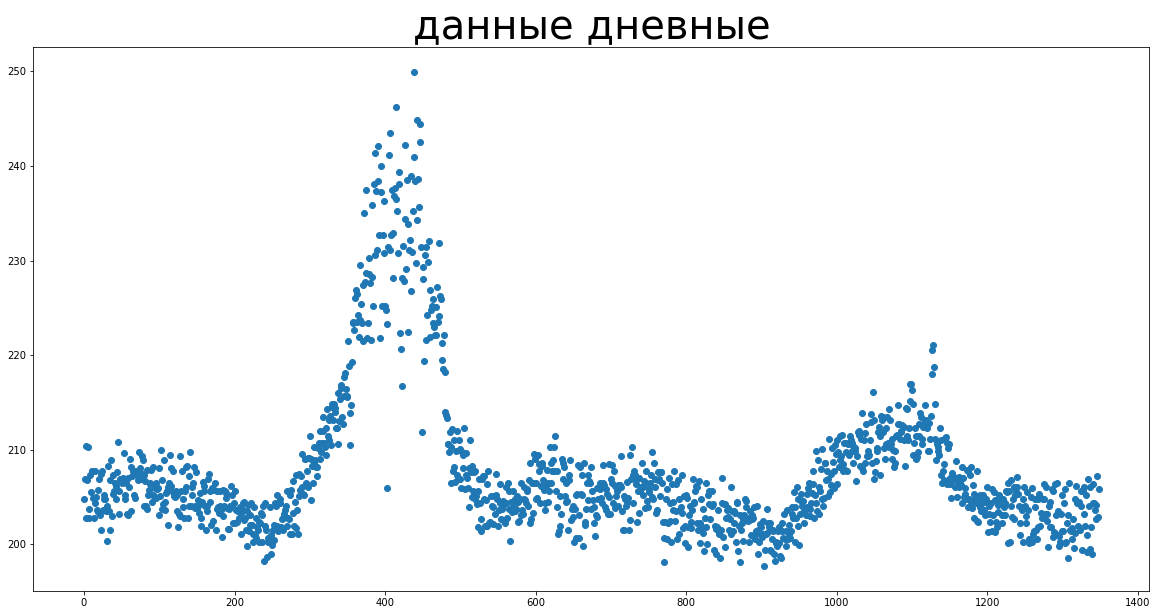

In [144]:
plt.figure(figsize=(20,10))
plt.title('данные дневные', fontsize=40)
plt.scatter(x=range(1349), y=vd_value[:1349]) 

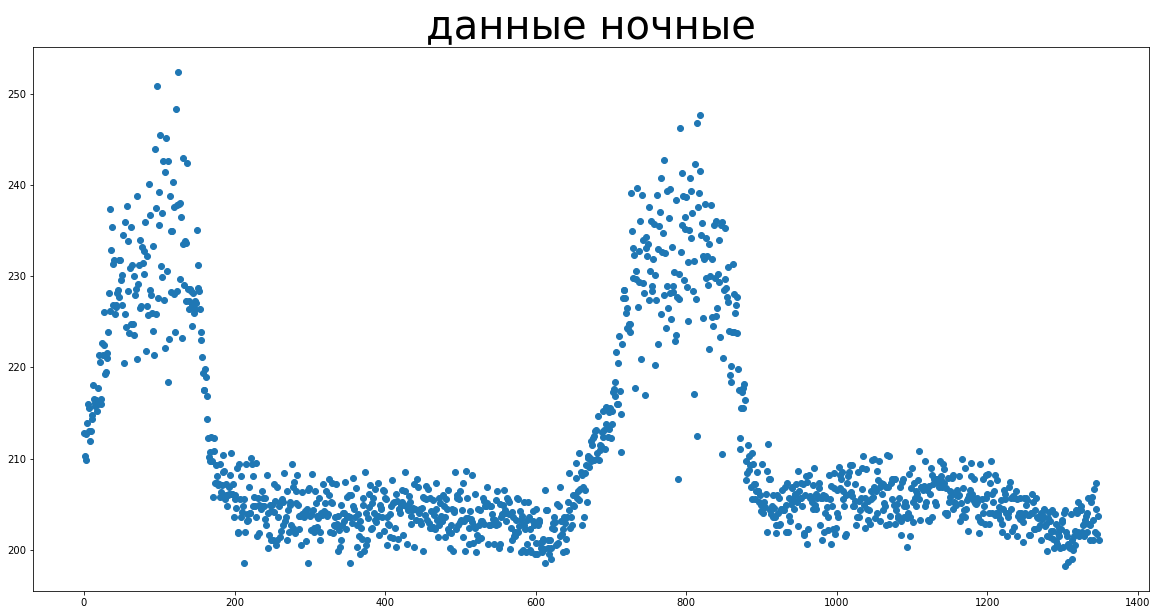

In [145]:
plt.figure(figsize=(20,10))
plt.title('данные ночные', fontsize=40)
plt.scatter(x=range(1349), y=vn_value[:1349]) 

### Очевидно, что тренировочные данные, в отличае от проверочных, крайне зашумлены, поэтому следует произвести интерполяцию

In [146]:
s_test = s.iloc[:1349]

In [147]:
s_test

,TimeValue,Value|Ìàêñèìóì
0,01.03.2019 0:00:09,194.281464
1,01.03.2019 0:01:10,189.149501
2,01.03.2019 0:02:10,185.483813
3,01.03.2019 0:03:10,187.683226
4,01.03.2019 0:04:10,186.216950
...,...,...
1344,01.03.2019 23:08:36,192.815189
1345,01.03.2019 23:09:36,189.882638
1346,01.03.2019 23:10:36,192.815189
1347,01.03.2019 23:11:36,193.548326


In [148]:

s_test.index = pd.to_datetime(s_test.TimeValue, dayfirst=True)
s_test.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

# s_samp = s_samp.iloc[:1]     # "Откусываем" пример длинной xLen
s_test = s_test.Value.resample('s').interpolate()
s_test = s_test.resample('1T').asfreq()
s_test = s_test.dropna()

s_test

TimeValue
2019-03-01 00:01:00    189.990806
2019-03-01 00:02:00    186.094761
2019-03-01 00:03:00    187.316657
2019-03-01 00:04:00    186.461330
2019-03-01 00:05:00    188.070388
                          ...    
2019-03-01 23:08:00    191.055659
2019-03-01 23:09:00    191.642169
2019-03-01 23:10:00    191.055659
2019-03-01 23:11:00    193.108444
2019-03-01 23:12:00    192.668561
Freq: T, Name: Value, Length: 1392, dtype: float64

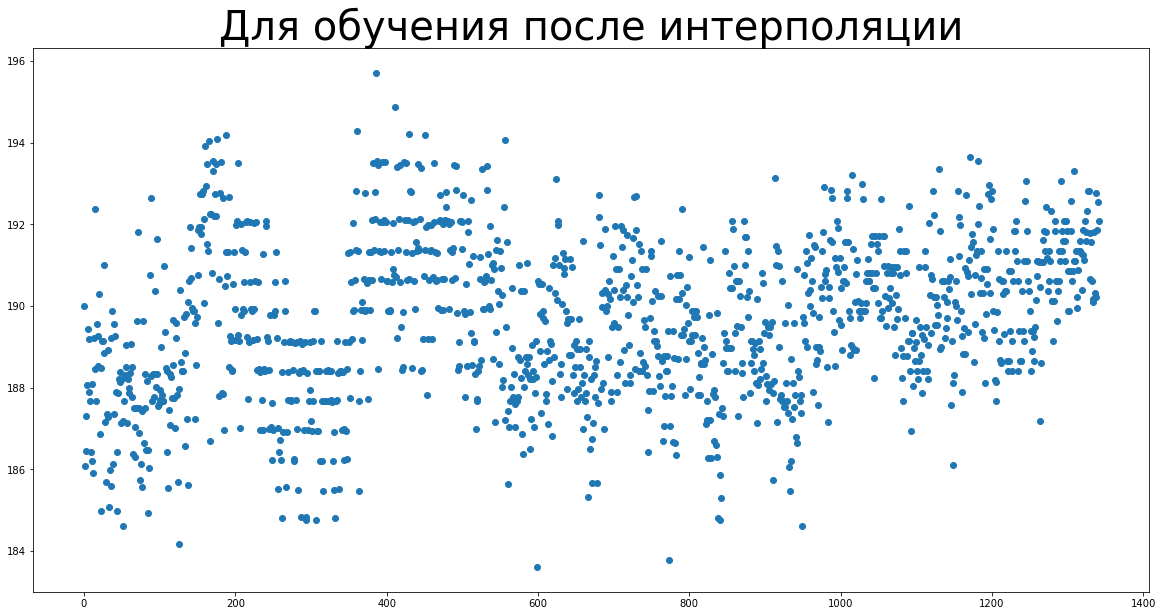

In [149]:
plt.figure(figsize=(20,10))
plt.title('Для обучения после интерполяции', fontsize=40)
plt.scatter(x=range(1342), y=s_test.values[:1342]) 

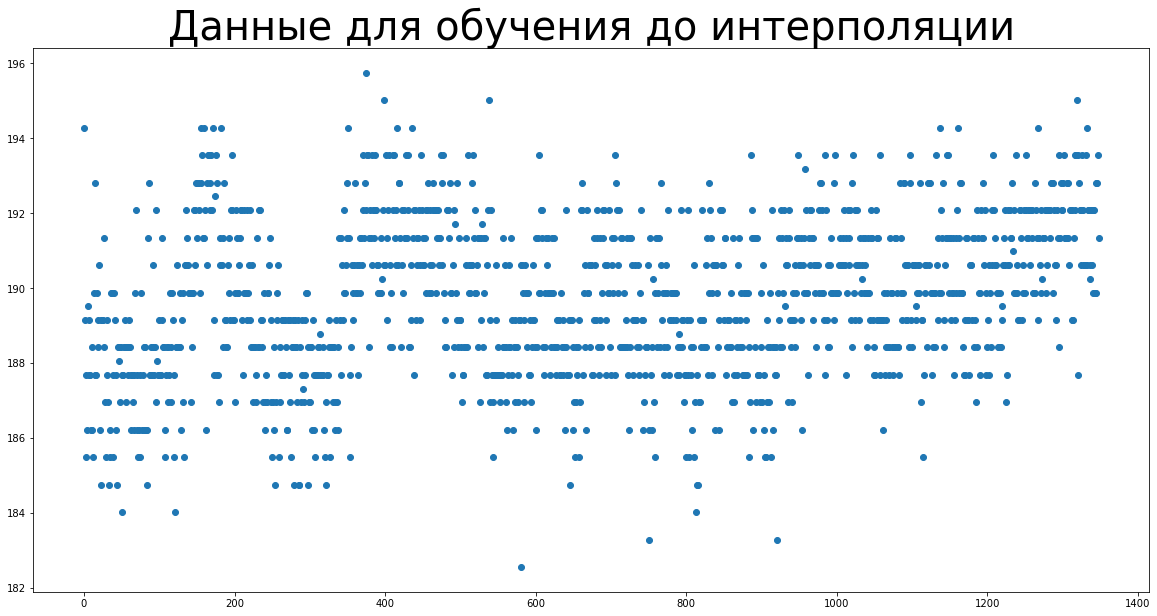

In [150]:
plt.figure(figsize=(20,10))
plt.title('Данные для обучения до интерполяции', fontsize=40)
plt.scatter(x=range(1349), y=s_value[:1349]) 

### Данные для обучения после интерполяции выглядят немного лучше 

In [151]:
s_test = s.iloc[:1349]

s_test.index = pd.to_datetime(s_test.TimeValue, dayfirst=True)
s_test.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

# s_samp = s_samp.iloc[:1]     # "Откусываем" пример длинной xLen
s_test = s_test.Value.resample('s').interpolate().resample('4T').interpolate().resample('1T').interpolate()
#s_test = s_test.Value.resample('5T').interpolate()
#s_test = s_test.resample('1T').asfreq()
s_test = s_test.dropna()

s_test

TimeValue
2019-03-01 00:04:00    186.461330
2019-03-01 00:05:00    186.821789
2019-03-01 00:06:00    187.182248
2019-03-01 00:07:00    187.542708
2019-03-01 00:08:00    187.903167
                          ...    
2019-03-01 23:08:00    191.055659
2019-03-01 23:09:00    191.458884
2019-03-01 23:10:00    191.862110
2019-03-01 23:11:00    192.265336
2019-03-01 23:12:00    192.668561
Freq: T, Name: Value, Length: 1389, dtype: float64

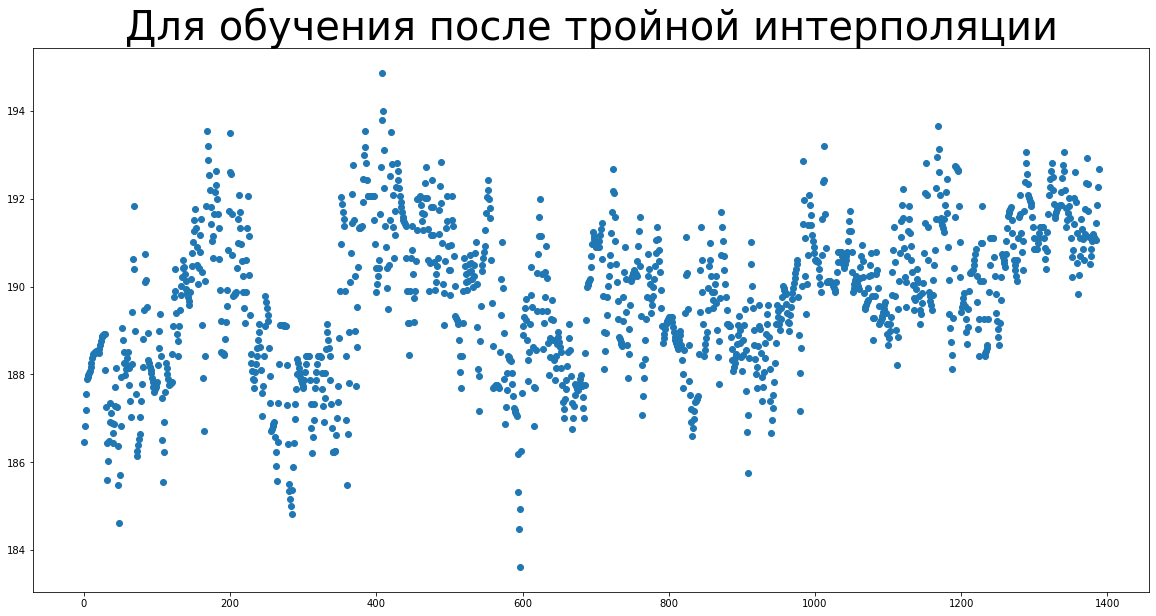

In [152]:
plt.figure(figsize=(20,10))
plt.title('Для обучения после тройной интерполяции', fontsize=40)
plt.scatter(x=range(1389), y=s_test.values[:1389]) 

### Прихожу к выводу, что из тройной интерполяции у НС больше шансов научиться улавливать динамику изменения значений

# Основная обработка

**Так как значений очень много, а интерполяцию следует произвести по всем обучающим данным, то следует интерполировать данные по частям, иначе в один момент времени в нашу оперативку прилетит около 50млн значений.**

In [153]:
s

,TimeValue,Value|Ìàêñèìóì
0,01.03.2019 0:00:09,194.281464
1,01.03.2019 0:01:10,189.149501
2,01.03.2019 0:02:10,185.483813
3,01.03.2019 0:03:10,187.683226
4,01.03.2019 0:04:10,186.216950
...,...,...
896765,05.08.2021 11:46:15,202.644217
896766,05.08.2021 11:48:22,204.193962
896767,05.08.2021 11:50:39,207.214415
896768,05.08.2021 11:52:48,202.937543


In [154]:
s.isna().sum()

TimeValue         0
Value|Ìàêñèìóì    0
dtype: int64

In [155]:
s[s['Value|Ìàêñèìóì'] == 0].value_counts

<bound method DataFrame.value_counts of                   TimeValue  Value|Ìàêñèìóì
101431  14.05.2019 14:43:10             0.0
101432  14.05.2019 14:44:39             0.0
101433  14.05.2019 14:46:09             0.0
101434  14.05.2019 14:47:09             0.0
101435  14.05.2019 14:48:09             0.0
...                     ...             ...
325235  27.12.2019 20:16:49             0.0
325238  27.12.2019 20:54:42             0.0
490391  21.04.2020 15:55:52             0.0
542542  28.05.2020 10:35:46             0.0
542543  28.05.2020 10:37:45             0.0

[78063 rows x 2 columns]>

In [156]:
mask = (s['Value|Ìàêñèìóì'] != 0)

In [157]:
s = s[mask]

In [158]:
s

,TimeValue,Value|Ìàêñèìóì
0,01.03.2019 0:00:09,194.281464
1,01.03.2019 0:01:10,189.149501
2,01.03.2019 0:02:10,185.483813
3,01.03.2019 0:03:10,187.683226
4,01.03.2019 0:04:10,186.216950
...,...,...
896765,05.08.2021 11:46:15,202.644217
896766,05.08.2021 11:48:22,204.193962
896767,05.08.2021 11:50:39,207.214415
896768,05.08.2021 11:52:48,202.937543


In [159]:
s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818707 entries, 0 to 896769
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TimeValue       818707 non-null  object 
 1   Value|Ìàêñèìóì  818707 non-null  float64
dtypes: float64(1), object(1)
memory usage: 18.7+ MB


In [160]:
# удастоверимся что все строки уникальны
s.TimeValue.unique().shape

(818707,)

In [163]:
s.shape

(818707, 2)

In [165]:
s['Value|Ìàêñèìóì'].shape

(818707,)

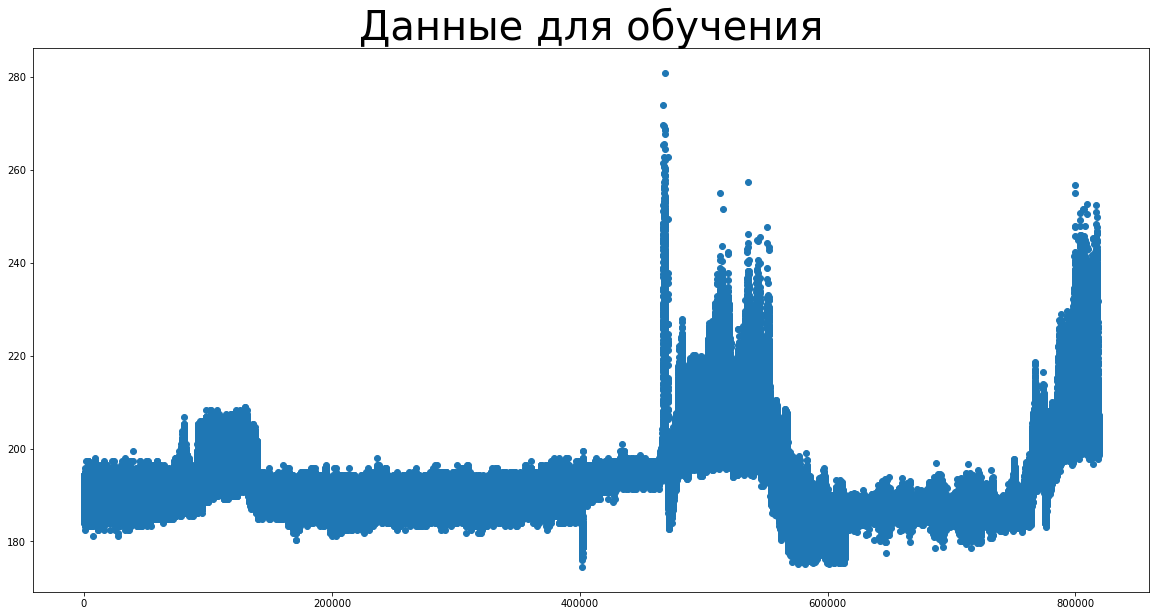

In [168]:
plt.figure(figsize=(20,10))
plt.title('Данные для обучения', fontsize=40)
plt.scatter(x=range(s['Value|Ìàêñèìóì'].shape[0]), y=s['Value|Ìàêñèìóì'].values[:]) 

In [169]:
##########################################################################################
# Конвертируем TimeValue в тип Timestamp и делаем его индексным сталбцом исходной таблицы.
##########################################################################################

t1 = time.time()

s_10 = s.iloc[:200000]
s_10.index = pd.to_datetime(s_10.TimeValue, dayfirst=True)
s_10.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

print(time.time() - t1)

26.025119304656982


In [170]:
s_10

,TimeValue,Value
TimeValue,,
2019-03-01 00:00:09,01.03.2019 0:00:09,194.281464
2019-03-01 00:01:10,01.03.2019 0:01:10,189.149501
2019-03-01 00:02:10,01.03.2019 0:02:10,185.483813
2019-03-01 00:03:10,01.03.2019 0:03:10,187.683226
2019-03-01 00:04:10,01.03.2019 0:04:10,186.216950
...,...,...
2019-11-24 16:08:32,24.11.2019 16:08:32,185.483813
2019-11-24 16:09:32,24.11.2019 16:09:32,185.483813
2019-11-24 16:10:32,24.11.2019 16:10:32,186.216950


## Шаблон для конкатинации

In [171]:
s_samp = s.iloc[:1]
s_samp.index = pd.to_datetime(s_samp.TimeValue, dayfirst=True)
s_samp.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

s_samp = s_samp.iloc[:1]     # "Откусываем" пример длинной xLen
s_samp = s_samp.Value.resample('s').interpolate()

s_samp # исполбзуется в create_samples

TimeValue
2019-03-01 00:00:09    194.281464
Freq: S, Name: Value, dtype: float64

In [172]:
########################################################
# Функция интерполяции всего массива значений по частям.
########################################################

def create_samples(data, xLen, step):
           
    data_len = data.iloc[:].shape[0]
    index = 0            
    count = 0
    
    
    batch_sum = s_samp   # берём шаблон для конкатинации Serias объектов
    
    while (index + xLen <= data_len):          # Идём по всей длине массива значений
        t1 = time.time()
        
        batch = data.iloc[index:index+xLen]     # "Откусываем" пример длинной xLen
      
        batch = batch.Value.resample('s').interpolate().resample('4T').interpolate().resample('1T').interpolate()
               
        batch = batch.dropna()
     
        now_shape = batch.shape[0]
     
        count += now_shape
        
        batch_sum = pd.concat([batch_sum, batch])
        
        index += step                          # Смещаеммся вперёд на step
        
        if index % step == 0:
            print(index, time.time()-t1)
            
    print(count)
    
    return batch_sum

In [173]:
s_10.shape

(200000, 2)

In [174]:
batch_sum = create_samples(s_10, 1000, 1000)

1000 0.03297877311706543
2000 0.03298139572143555
3000 0.03398561477661133
4000 0.02998495101928711
5000 0.028980731964111328
6000 0.027004718780517578
7000 0.024983644485473633
8000 0.0259859561920166
9000 0.0289614200592041
10000 0.03000497817993164
11000 0.027963876724243164
12000 0.02498650550842285
13000 0.025981426239013672
14000 0.026012420654296875
15000 0.025985002517700195
16000 0.02600836753845215
17000 0.03296041488647461
18000 0.028985977172851562
19000 0.025979995727539062
20000 0.025985002517700195
21000 0.024985551834106445
22000 0.02498626708984375
23000 0.02598428726196289
24000 0.026984691619873047
25000 0.034983158111572266
26000 0.02898263931274414
27000 0.029982805252075195
28000 0.025986194610595703
29000 0.027980327606201172
30000 0.025985240936279297
31000 0.024985790252685547
32000 0.025985240936279297
33000 0.032981157302856445
34000 0.026987552642822266
35000 0.026005983352661133
36000 0.02597832679748535
37000 0.02600574493408203
38000 0.028987407684326172


### Подготовка к нормализации
**Нормализация происходит очень быстро и почти не затрачивает ресурсов, поэтому её можно произвести на всех данных сразу**

In [175]:
batch_sum.shape

(386121,)

In [177]:
batch_sum.values

array([194.281464  , 186.4613296 , 186.82178892, ..., 185.15429504,
       185.36792976, 185.58156448])

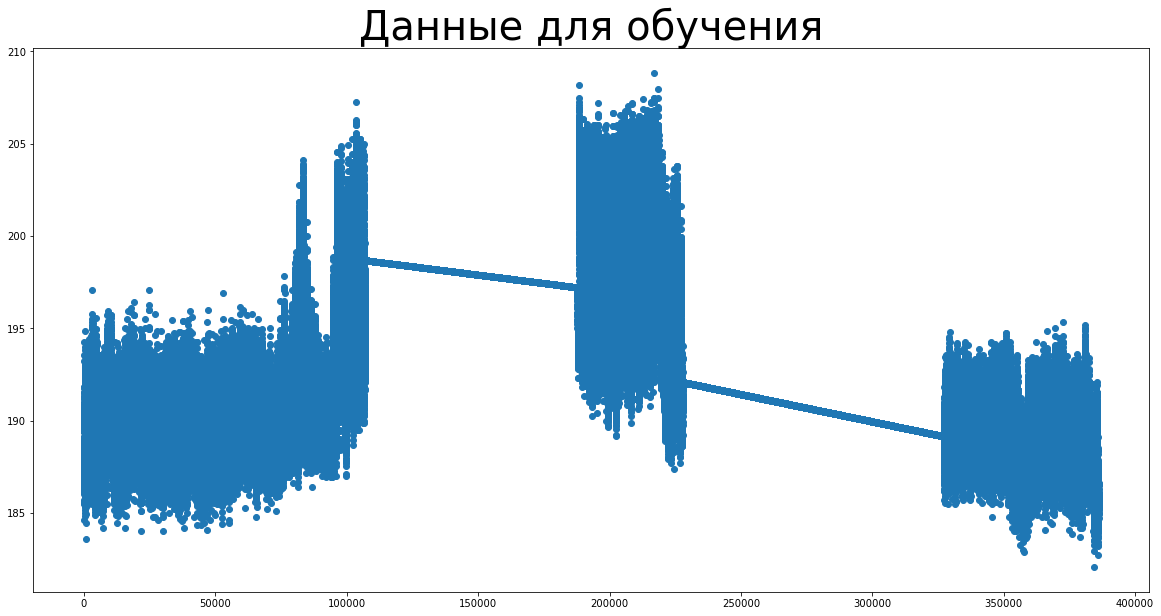

In [183]:
plt.figure(figsize=(20,10))
plt.title('Данные для обучения', fontsize=40)
plt.scatter(x=range(batch_sum.shape[0]), y=batch_sum.values[:]) 
plt.show()

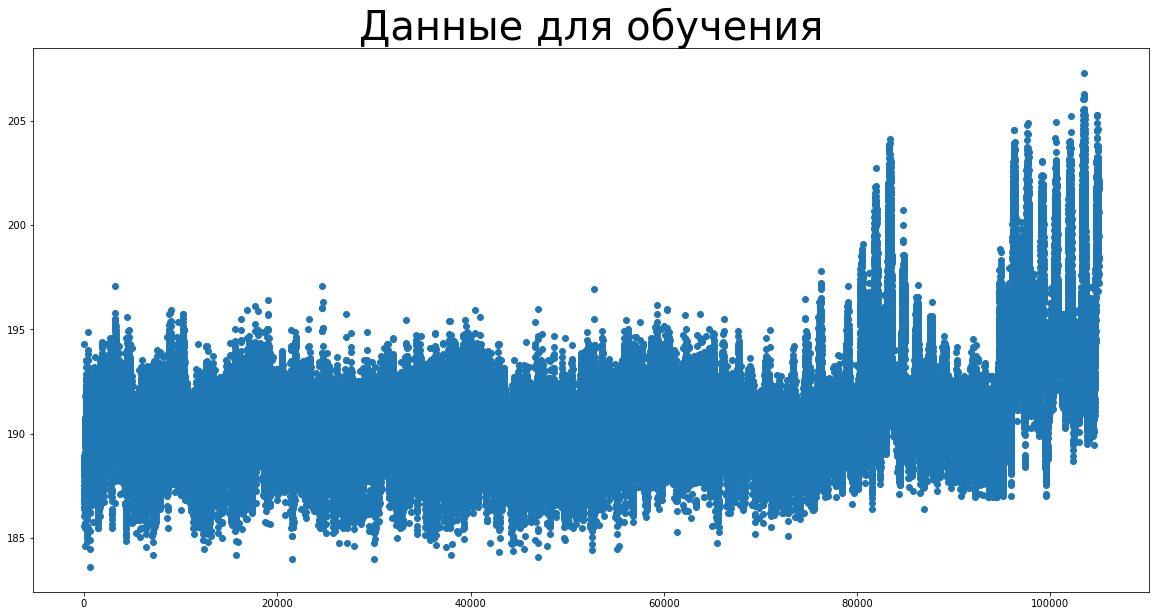

In [185]:
plt.figure(figsize=(20,10))
plt.title('Данные для обучения', fontsize=40)
plt.scatter(x=range(105000), y=batch_sum.values[:105000]) 
plt.show()

In [186]:
##########################################################################################
# Конвертируем TimeValue в тип Timestamp и делаем его индексным сталбцом исходной таблицы.
##########################################################################################

t1 = time.time()

s_10 = s.iloc[:105000]
s_10.index = pd.to_datetime(s_10.TimeValue, dayfirst=True)
s_10.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

print(time.time() - t1)

13.124870300292969


In [192]:
batch_sum = batch_sum[:105000]

In [194]:
batch_sum.shape

(105000,)

In [195]:
res = batch_sum.to_frame()
res_v = batch_sum.values

In [196]:
Scaler = MinMaxScaler()
res_v = Scaler.fit_transform(res_v.reshape(-1,1))
res.Value = res_v
res_v = res_v.reshape(res_v.shape[0])

In [197]:
res

,Value
TimeValue,
2019-03-01 00:00:09,0.450822
2019-03-01 00:04:00,0.120490
2019-03-01 00:05:00,0.135716
2019-03-01 00:06:00,0.150943
2019-03-01 00:07:00,0.166169
...,...
2019-05-13 04:23:00,0.622440
2019-05-13 04:24:00,0.574697
2019-05-13 04:25:00,0.592117


In [198]:
res_v.shape

(105000,)

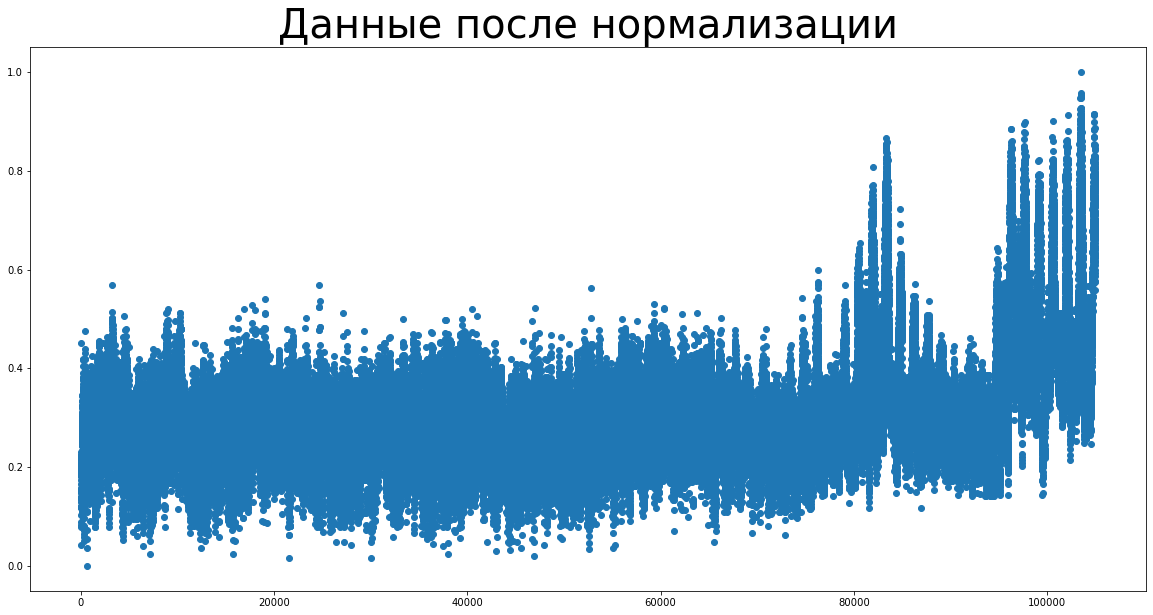

In [200]:
plt.figure(figsize=(20,10))
plt.title('Данные после нормализации', fontsize=40)
plt.scatter(x=range(res_v.shape[0]), y=res_v) # res_v.shape[0]
plt.show()

In [201]:
res.columns

Index(['Value'], dtype='object')

In [202]:
res.columns

Index(['Value'], dtype='object')

In [203]:
res

,Value
TimeValue,
2019-03-01 00:00:09,0.450822
2019-03-01 00:04:00,0.120490
2019-03-01 00:05:00,0.135716
2019-03-01 00:06:00,0.150943
2019-03-01 00:07:00,0.166169
...,...
2019-05-13 04:23:00,0.622440
2019-05-13 04:24:00,0.574697
2019-05-13 04:25:00,0.592117


In [204]:
# создание обрабатываемого набора и именование
resedit=res
resedit.Value.name='Minus 0 minut'  # ЗАМЕНИЛ Minus 1440 minut

In [205]:
resedit.columns

Index(['Value'], dtype='object')

In [206]:
###################################################
# создание и именование датафрейма скользящим окон.
###################################################

n=20 # шаг

allres=[] # лист из семплов

for i in range(0,73):
    res1=resedit.Value.shift(periods=-n*i)   # обращение к Series фрейма
    res1.name='Minus '+str(n*i)+' minut'     # ЗАМЕНИЛ (1440 - n*i) НА n*i
    allres.append(res1)

# [1,2,3,4,5] -> [2,3,4,5,Nan] -> [3,4,5,NaN,NaN]...  
    
for i in allres:
    resedit=pd.concat([resedit,i],axis=1)
    

In [207]:
len(resedit.columns)

74

In [208]:
resedit.head()

,Value,Minus 0 minut,Minus 20 minut,Minus 40 minut,Minus 60 minut,Minus 80 minut,Minus 100 minut,Minus 120 minut,Minus 140 minut,Minus 160 minut,...,Minus 1260 minut,Minus 1280 minut,Minus 1300 minut,Minus 1320 minut,Minus 1340 minut,Minus 1360 minut,Minus 1380 minut,Minus 1400 minut,Minus 1420 minut,Minus 1440 minut
TimeValue,,,,,,,,,,,,,,,,,,,,,
2019-03-01 00:00:09,0.450822,0.450822,0.206557,0.129136,0.201259,0.176234,0.175923,0.177524,0.275075,0.319206,...,0.313786,0.321786,0.306302,0.373401,0.363336,0.299076,0.317657,0.212364,0.188879,0.218558
2019-03-01 00:04:00,0.120490,0.120490,0.206170,0.119458,0.206686,0.192234,0.178298,0.178298,0.268107,0.334690,...,0.326045,0.303721,0.306302,0.381143,0.345142,0.317141,0.316109,0.186040,0.199847,0.198428
2019-03-01 00:05:00,0.135716,0.135716,0.210041,0.137437,0.191202,0.219590,0.194557,0.205396,0.264236,0.283721,...,0.338303,0.285656,0.306302,0.388885,0.326948,0.335206,0.314560,0.159717,0.210815,0.178298
2019-03-01 00:06:00,0.150943,0.150943,0.213912,0.155416,0.175718,0.246945,0.210815,0.232493,0.260365,0.232751,...,0.340368,0.314044,0.311463,0.375723,0.333916,0.325399,0.331593,0.156620,0.177911,0.175201
2019-03-01 00:07:00,0.166169,0.166169,0.217783,0.173395,0.160233,0.274301,0.227074,0.259591,0.256494,0.181782,...,0.342432,0.342432,0.316625,0.362562,0.340884,0.315593,0.348626,0.153523,0.145007,0.172105


In [209]:
resedit.drop('Value', axis=1, inplace=True)

In [210]:
# создание дамми-параметров по месяцу и часу
resedit.insert(0,'Month',(resedit.index + timedelta(minutes=1680)).month)
resedit.insert(0,'Hour',(resedit.index + timedelta(minutes=1680)).hour)
resedit=pd.get_dummies(resedit,columns=['Month'])
resedit=pd.get_dummies(resedit,columns=['Hour'])

In [211]:
resedit.columns

Index(['Minus 0 minut', 'Minus 20 minut', 'Minus 40 minut', 'Minus 60 minut',
       'Minus 80 minut', 'Minus 100 minut', 'Minus 120 minut',
       'Minus 140 minut', 'Minus 160 minut', 'Minus 180 minut',
       'Minus 200 minut', 'Minus 220 minut', 'Minus 240 minut',
       'Minus 260 minut', 'Minus 280 minut', 'Minus 300 minut',
       'Minus 320 minut', 'Minus 340 minut', 'Minus 360 minut',
       'Minus 380 minut', 'Minus 400 minut', 'Minus 420 minut',
       'Minus 440 minut', 'Minus 460 minut', 'Minus 480 minut',
       'Minus 500 minut', 'Minus 520 minut', 'Minus 540 minut',
       'Minus 560 minut', 'Minus 580 minut', 'Minus 600 minut',
       'Minus 620 minut', 'Minus 640 minut', 'Minus 660 minut',
       'Minus 680 minut', 'Minus 700 minut', 'Minus 720 minut',
       'Minus 740 minut', 'Minus 760 minut', 'Minus 780 minut',
       'Minus 800 minut', 'Minus 820 minut', 'Minus 840 minut',
       'Minus 860 minut', 'Minus 880 minut', 'Minus 900 minut',
       'Minus 920 minut', '

In [212]:
resedit.head(3)

,Minus 0 minut,Minus 20 minut,Minus 40 minut,Minus 60 minut,Minus 80 minut,Minus 100 minut,Minus 120 minut,Minus 140 minut,Minus 160 minut,Minus 180 minut,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
TimeValue,,,,,,,,,,,,,,,,,,,,,
2019-03-01 00:00:09,0.450822,0.206557,0.129136,0.201259,0.176234,0.175923,0.177524,0.275075,0.319206,0.360723,...,0,0,0,0,0,0,0,0,0,0
2019-03-01 00:04:00,0.120490,0.206170,0.119458,0.206686,0.192234,0.178298,0.178298,0.268107,0.334690,0.381659,...,0,0,0,0,0,0,0,0,0,0
2019-03-01 00:05:00,0.135716,0.210041,0.137437,0.191202,0.219590,0.194557,0.205396,0.264236,0.283721,0.367723,...,0,0,0,0,0,0,0,0,0,0


In [213]:
# подгонка под шаблон датафрейма для подачи в сеть 

c1 = []

for i in range(0, 1441, 20):
    c1.append(f'Minus {i} minut')

for i in range(1, 13, 1):
    c1.append(f'Month_{i}')   

for i in range(24):
    c1.append(f'Hour_{i}')  
    
print(c1)


['Minus 0 minut', 'Minus 20 minut', 'Minus 40 minut', 'Minus 60 minut', 'Minus 80 minut', 'Minus 100 minut', 'Minus 120 minut', 'Minus 140 minut', 'Minus 160 minut', 'Minus 180 minut', 'Minus 200 minut', 'Minus 220 minut', 'Minus 240 minut', 'Minus 260 minut', 'Minus 280 minut', 'Minus 300 minut', 'Minus 320 minut', 'Minus 340 minut', 'Minus 360 minut', 'Minus 380 minut', 'Minus 400 minut', 'Minus 420 minut', 'Minus 440 minut', 'Minus 460 minut', 'Minus 480 minut', 'Minus 500 minut', 'Minus 520 minut', 'Minus 540 minut', 'Minus 560 minut', 'Minus 580 minut', 'Minus 600 minut', 'Minus 620 minut', 'Minus 640 minut', 'Minus 660 minut', 'Minus 680 minut', 'Minus 700 minut', 'Minus 720 minut', 'Minus 740 minut', 'Minus 760 minut', 'Minus 780 minut', 'Minus 800 minut', 'Minus 820 minut', 'Minus 840 minut', 'Minus 860 minut', 'Minus 880 minut', 'Minus 900 minut', 'Minus 920 minut', 'Minus 940 minut', 'Minus 960 minut', 'Minus 980 minut', 'Minus 1000 minut', 'Minus 1020 minut', 'Minus 1040 min

In [214]:
df_ = pd.DataFrame(columns=c1)

In [215]:
df_

,Minus 0 minut,Minus 20 minut,Minus 40 minut,Minus 60 minut,Minus 80 minut,Minus 100 minut,Minus 120 minut,Minus 140 minut,Minus 160 minut,Minus 180 minut,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23


In [216]:

df_ = pd.DataFrame(columns=c1)
frames = [df_, resedit]
resedit = pd.concat(frames, sort=False)


In [217]:
resedit.head(3)

,Minus 0 minut,Minus 20 minut,Minus 40 minut,Minus 60 minut,Minus 80 minut,Minus 100 minut,Minus 120 minut,Minus 140 minut,Minus 160 minut,Minus 180 minut,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
2019-03-01 00:00:09,0.450822,0.206557,0.129136,0.201259,0.176234,0.175923,0.177524,0.275075,0.319206,0.360723,...,0,0,0,0,0,0,0,0,0,0
2019-03-01 00:04:00,0.120490,0.206170,0.119458,0.206686,0.192234,0.178298,0.178298,0.268107,0.334690,0.381659,...,0,0,0,0,0,0,0,0,0,0
2019-03-01 00:05:00,0.135716,0.210041,0.137437,0.191202,0.219590,0.194557,0.205396,0.264236,0.283721,0.367723,...,0,0,0,0,0,0,0,0,0,0


In [218]:
res = res.Value

In [219]:
# создание колонки прогноза на 4 часа
dfprog=res.shift(periods=-1680)
dfprog.name='Prognoz 4 hour'
dfopor=pd.concat([resedit,dfprog], axis=1)

In [220]:
dfopor.head()

,Minus 0 minut,Minus 20 minut,Minus 40 minut,Minus 60 minut,Minus 80 minut,Minus 100 minut,Minus 120 minut,Minus 140 minut,Minus 160 minut,Minus 180 minut,...,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Prognoz 4 hour
2019-03-01 00:00:09,0.450822,0.206557,0.129136,0.201259,0.176234,0.175923,0.177524,0.275075,0.319206,0.360723,...,0,0,0,0,0,0,0,0,0,0.404886
2019-03-01 00:04:00,0.120490,0.206170,0.119458,0.206686,0.192234,0.178298,0.178298,0.268107,0.334690,0.381659,...,0,0,0,0,0,0,0,0,0,0.397402
2019-03-01 00:05:00,0.135716,0.210041,0.137437,0.191202,0.219590,0.194557,0.205396,0.264236,0.283721,0.367723,...,0,0,0,0,0,0,0,0,0,0.389917
2019-03-01 00:06:00,0.150943,0.213912,0.155416,0.175718,0.246945,0.210815,0.232493,0.260365,0.232751,0.353787,...,0,0,0,0,0,0,0,0,0,0.324238
2019-03-01 00:07:00,0.166169,0.217783,0.173395,0.160233,0.274301,0.227074,0.259591,0.256494,0.181782,0.339851,...,0,0,0,0,0,0,0,0,0,0.258559


In [221]:
# создание колонок меток времени для старта и прогноза
dfopor['Data_Time_Start'] = dfopor.index + timedelta(minutes=1440)
dfopor['Data_Time_Prognoz'] = dfopor.index + timedelta(minutes=1680)

In [222]:
dfopor.shape

(105000, 112)

In [223]:
# сброс строк без целевой переменной
Test_sub=dfopor.dropna(subset=['Prognoz 4 hour'],axis=0)

In [224]:
Test_sub.shape

(103320, 112)

In [225]:
# набор для обучения (109 входов и целевая переменная)
X_test_sub=Test_sub.iloc[:,:110]

In [226]:
# заполнение пустых дамми-значений
X_test_sub=X_test_sub.fillna(0)


In [227]:
# массивы входов и целевой переменной для подачи в сеть
X=X_test_sub.values[:,:109]
y=X_test_sub.values[:,109]

In [228]:
X

array([[0.45082245, 0.20655715, 0.1291355 , ..., 0.        , 0.        ,
        0.        ],
       [0.12049008, 0.20617004, 0.11945779, ..., 0.        , 0.        ,
        0.        ],
       [0.13571634, 0.21004112, 0.13743682, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.66450619, 0.7589606 , 0.8215431 , ..., 0.        , 0.        ,
        0.        ],
       [0.67689366, 0.7821871 , 0.85496345, ..., 0.        , 0.        ,
        0.        ],
       [0.68153896, 0.75883157, 0.83057563, ..., 0.        , 0.        ,
        0.        ]])

In [229]:
y

array([0.4048856 , 0.39740151, 0.38991742, ..., 0.59211695, 0.60953682,
       0.62695669])

In [230]:
res_v.shape

(105000,)

## Modelling

In [231]:
# модель нейросети
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)


input_shape = (109, ) # был косяк в размерности (1, 109), я поставил (109, )
print(f'Feature shape: {input_shape}')

Feature shape: (109,)


In [66]:
##########################
# Функция создания модели.
##########################

def create_model():

    model = Sequential()

    model.add(Dense(109, input_shape=input_shape, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(16, activation='relu'))

    model.add(Dense(1, activation='linear'))
    
    # компиляция модели

    model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    return model


In [67]:
######################################
#  Функция получения метрик и ошибки.
######################################

def show_losses(history):

    # графики обучения
    acc = history.history['log_cosh']
    val_acc = history.history['val_log_cosh']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    


In [68]:
################################
# Функция визуализации графиков.
################################

def showPredict(start, step, channel, predVal, yValUnscaled):
    '''
        start - точка с которой начинаем отрисовку графика
        step - длина графика, которую отрисовываем
        channel - какой канал отрисовываем  
  
    '''
    
    plt.figure(figsize=(22,6))
    plt.plot(predVal[start:start+step],#, 0],
             label='Прогноз')
    plt.plot(yValUnscaled[start:start+step],#, channel], 
             label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [69]:
############################################
# Расчет линейнного коэффициента корреляции.
############################################

def correlate(a, b):

  ma = a.mean() 
  mb = b.mean() 
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [70]:
#####################################################################################
# Расчитываем корелляцию между базовым рядом и предсказанным  с разныс сдвигом шагов.
#####################################################################################


def showCorr(channels, corrSteps, predVal, yValUnscaled):

    '''
        channels - по каким каналам отображать корреляцию
        corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции

    '''        
  # Проходим по всем каналам
    for ch in channels:
      corr = [] 
      yLen = yValUnscaled.shape[0] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        corr.append(correlate(yValUnscaled[:yLen-i], predVal[i:]))   
        own_corr = [] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        own_corr.append(correlate(yValUnscaled[:yLen-i], yValUnscaled[i:]))  

    # Отображаем график коррелций для данного шага
      plt.figure(figsize=(14,7))
      plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [71]:
############################################
# Функция отображения необходимых графиков.
############################################


def get_inf(model, window, steps):
    
    '''
    model - текущая модель
    window - кол-во значений на графике предсказанного временного ряда
    steps - кол-во сдвигов подсчета автокорелляции
    
    '''
    show_losses(history)
    predictions = model.predict(X, verbose=1) 
    showPredict(0,window,0,predictions,y)
    pred = predictions.reshape(predictions.shape[0])
    showCorr([0], steps, pred,y)
    

In [72]:
############
# Callbacks.
############

def create_call(name_model):
    
    checkpoint = ModelCheckpoint(path + name_model, verbose=1, monitor='val_log_cosh', save_best_only=True, mode='auto')
    earlystop = EarlyStopping(monitor='val_log_cosh', patience=10, restore_best_weights=True)
    callbacks_list = [checkpoint, earlystop]
    
    return callbacks_list

In [117]:
callbacks_list = create_call('model_1')

In [118]:
model_1 = create_model()

## Dense без нормализации

In [119]:
# обучение модели
history = model_1.fit(
        X, y, epochs=50, batch_size=1, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
7292/7312 [============================>.] - ETA: 0s - loss: 2.7949 - log_cosh: 2.1957
Epoch 00001: val_log_cosh improved from inf to 1.36168, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1\assets
7312/7312 [==============================] - 17s 2ms/step - loss: 2.7930 - log_cosh: 2.1938 - val_loss: 1.9345 - val_log_cosh: 1.3617
Epoch 2/50
7302/7312 [============================>.] - ETA: 0s - loss: 2.2534 - log_cosh: 1.6725
Epoch 00002: val_log_cosh did not improve from 1.36168
7312/7312 [==============================] - 16s 2ms/step - loss: 2.2519 - log_cosh: 1.6711 - val_loss: 2.8354 - val_log_cosh: 2.1906
Epoch 3/50
7294/7312 [============================>.] - ETA: 0s - loss: 2.1258 - log_cosh: 1.5506
Epoch 00003: val_log_cosh improved from 1.36168 to 0.76774, saving model to C

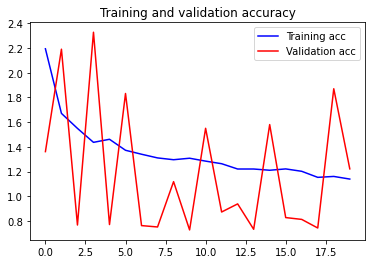

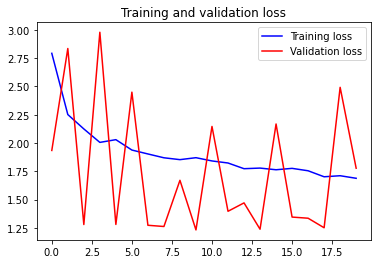

269/269 [==============================] - 0s 1ms/step


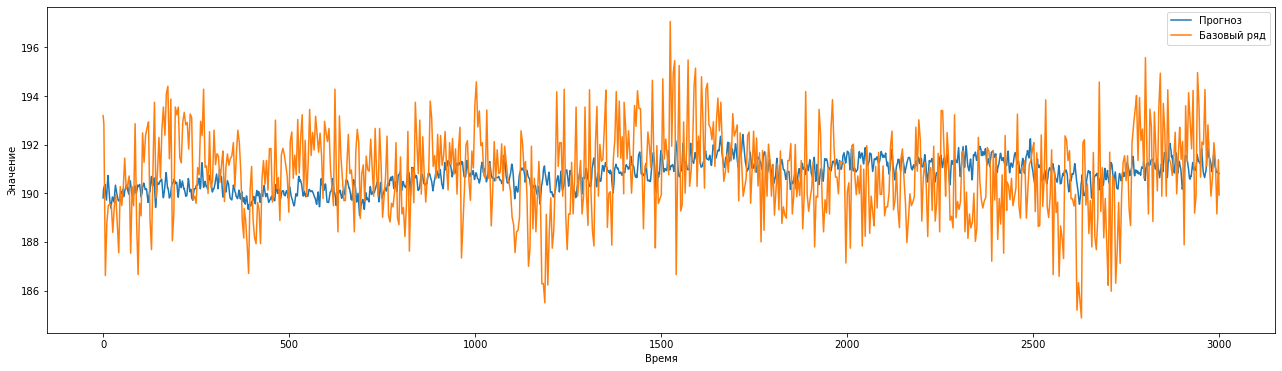

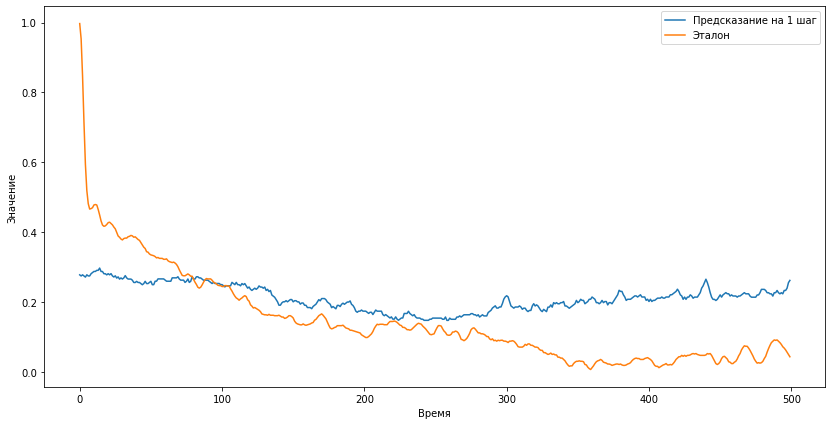

In [141]:
get_inf(model_1, 3000, 500)

In [147]:
model_1_load = create_model()

model_1.save(path + 'model_1.hdf5')
model_1_load.load_weights(path + 'model_1.hdf5')

## Dense + нормализация

In [192]:
model_2 = create_model()

In [193]:
# обучение модели
history = model_2.fit(
        X, y, epochs=50, batch_size=1, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
7309/7312 [============================>.] - ETA: 0s - loss: 0.1007 - log_cosh: 0.0080
Epoch 00001: val_log_cosh improved from 0.72813 to 0.00757, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1\assets
7312/7312 [==============================] - 17s 2ms/step - loss: 0.1008 - log_cosh: 0.0080 - val_loss: 0.0993 - val_log_cosh: 0.0076
Epoch 2/50
7297/7312 [============================>.] - ETA: 0s - loss: 0.0902 - log_cosh: 0.0065 E
Epoch 00002: val_log_cosh did not improve from 0.00757
7312/7312 [==============================] - 16s 2ms/step - loss: 0.0902 - log_cosh: 0.0065 - val_loss: 0.0995 - val_log_cosh: 0.0076
Epoch 3/50
7293/7312 [============================>.] - ETA: 0s - loss: 0.0861 - log_cosh: 0.0060
Epoch 00003: val_log_cosh did not improve from 0.00757
7312/7312 [=====

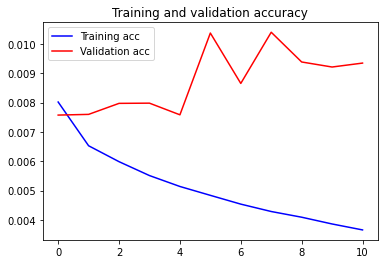

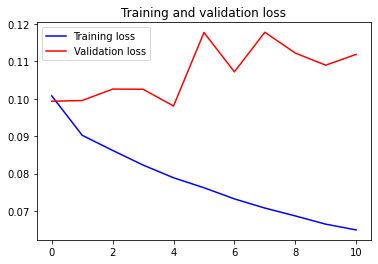

269/269 [==============================] - 0s 1ms/step


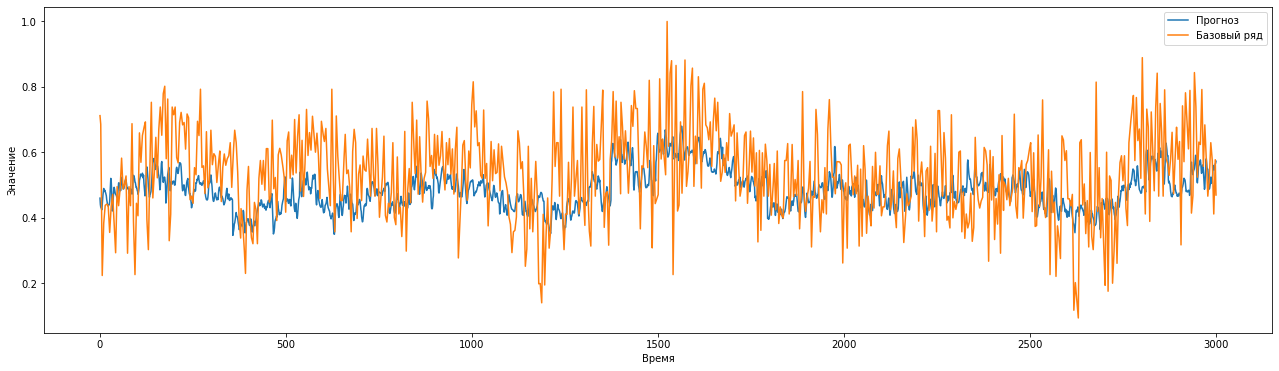

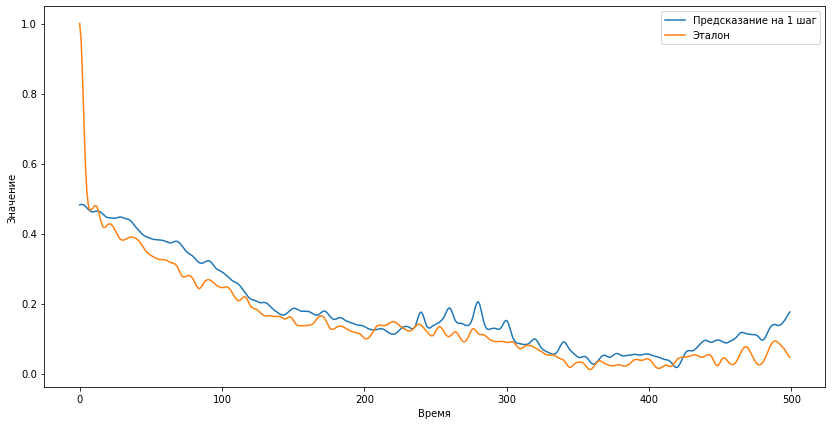

In [197]:
get_inf(model_2, 3000, 500)

269/269 [==============================] - 0s 1ms/step


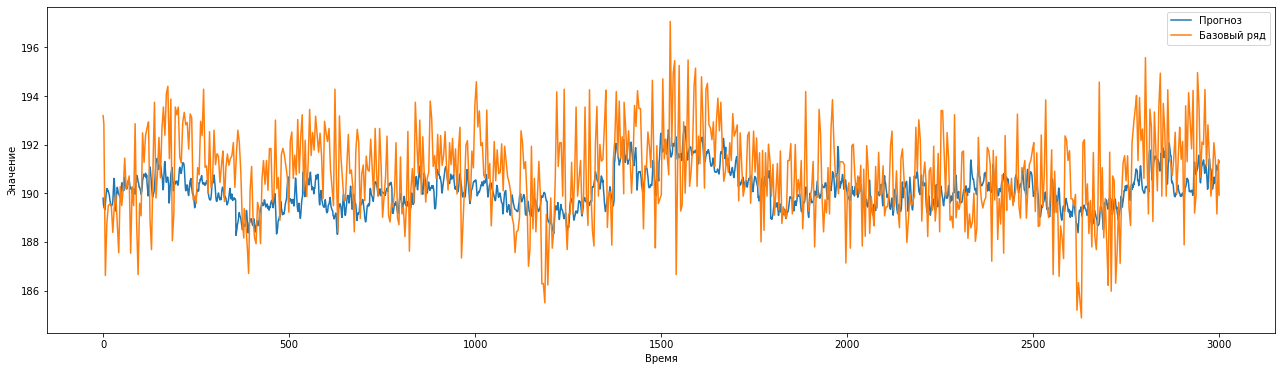

In [208]:
predictions = model_2.predict(X, verbose=1)
pred = Scaler.inverse_transform(predictions)
y_un = Scaler.inverse_transform(y.reshape(-1,1))
showPredict(0,3000,0,pred,y_un)

## Очевидно что точность на нормализованных данных гораздо лучше, поэтому будем работать с такими значениями и немного перепишем функции отображения

In [210]:
############################################
# Функция отображения необходимых графиков.
############################################


def get_inf(model, window, steps):
    
    '''
    model - текущая модель
    window - кол-во значений на графике предсказанного временного ряда
    steps - кол-во сдвигов подсчета автокорелляции
    
    '''
    show_losses(history)
    
    predictions = model.predict(X, verbose=1)
    pred = Scaler.inverse_transform(predictions)
    y_un = Scaler.inverse_transform(y.reshape(-1,1))
    
    showPredict(0,window,0,pred,y_un)
    
    pred = predictions.reshape(predictions.shape[0])
    showCorr([0], steps, pred,y)
    

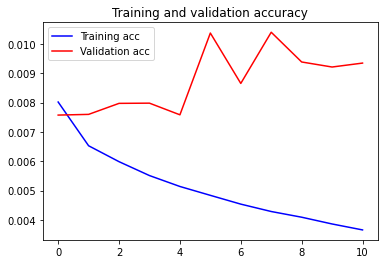

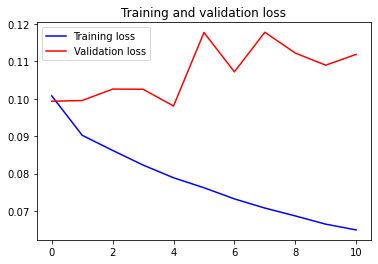

269/269 [==============================] - 0s 1ms/step


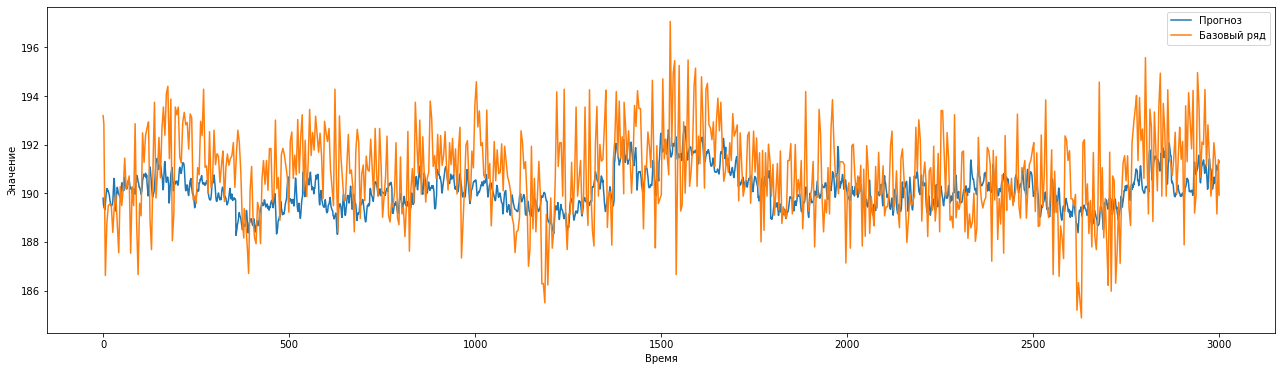

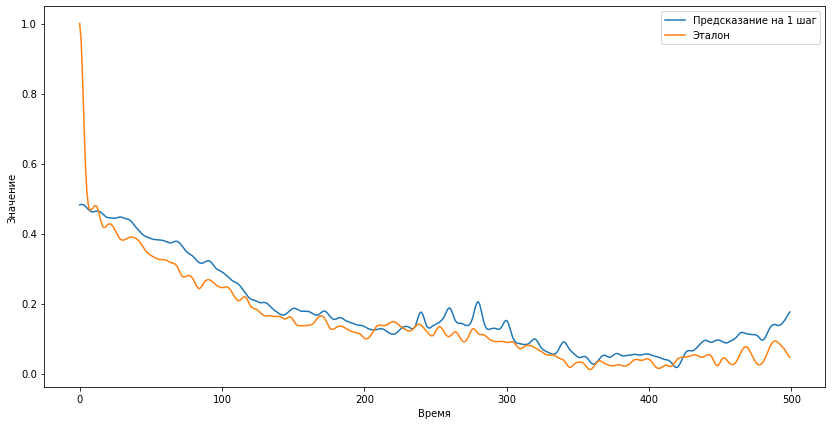

In [211]:
get_inf(model_2, 3000, 500)

## Одномерная свёртка

In [230]:
input_shape

(109,)

In [74]:
input_shape_conv = (109, 1)

In [75]:
input_shape_conv

(109, 1)

In [76]:
def conv_model():

    modelC = Sequential()

    modelC.add(Conv1D(64, 5, input_shape = input_shape_conv, activation="relu"))
    modelC.add(Conv1D(64, 5, activation="relu"))
    modelC.add(MaxPooling1D())
    modelC.add(Flatten())
    modelC.add(Dense(100, activation="relu"))
    modelC.add(Dense(1, activation="linear"))

    # компиляция модели

    modelC.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    modelC.summary()
    
    return modelC



In [259]:
model_C = conv_model()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 105, 64)           384       
                                                                 
 conv1d_11 (Conv1D)          (None, 101, 64)           20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dense_54 (Dense)            (None, 100)               320100    
                                                                 
 dense_55 (Dense)            (None, 1)                 101       
                                                     

In [260]:
callbacks_list = create_call('model_C')

In [261]:
# обучение модели
history = model_C.fit(
        X, y, epochs=50, batch_size=1, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
7304/7312 [============================>.] - ETA: 0s - loss: 0.0985 - log_cosh: 0.0076
Epoch 00001: val_log_cosh improved from inf to 0.00787, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_C
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_C\assets
7312/7312 [==============================] - 38s 5ms/step - loss: 0.0984 - log_cosh: 0.0076 - val_loss: 0.1006 - val_log_cosh: 0.0079
Epoch 2/50
7305/7312 [============================>.] - ETA: 0s - loss: 0.0892 - log_cosh: 0.0062
Epoch 00002: val_log_cosh improved from 0.00787 to 0.00574, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_C
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_C\assets
7312/7312 [==============================] - 36s 5ms/s

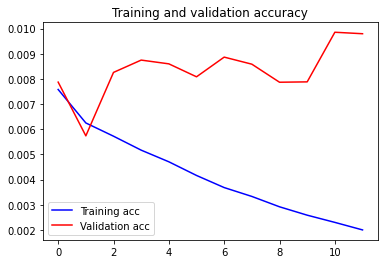

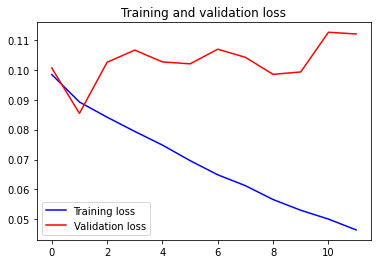

269/269 [==============================] - 1s 5ms/step


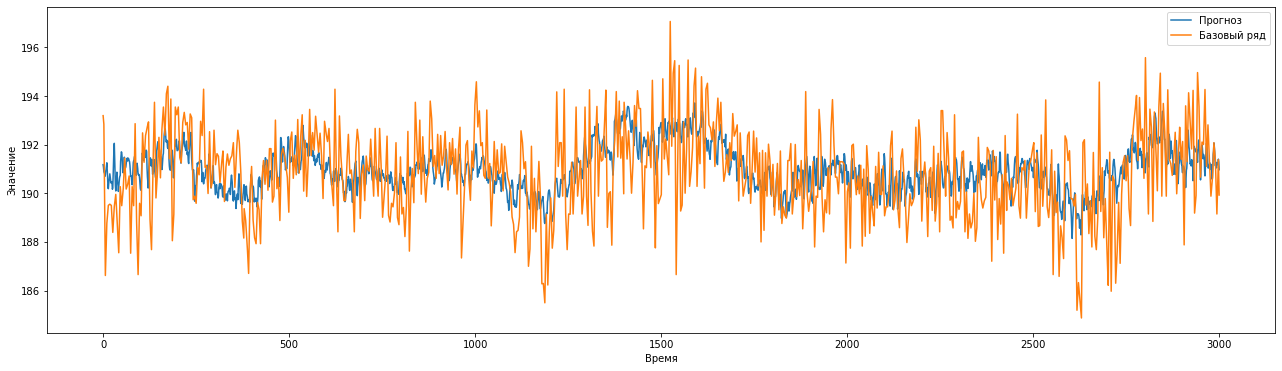

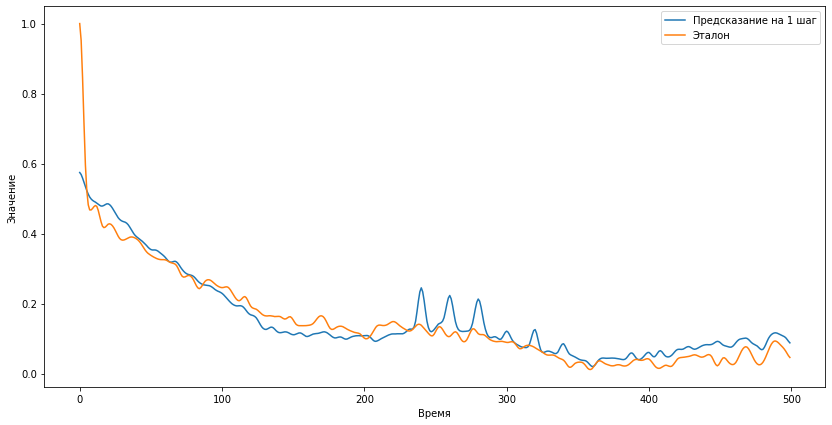

In [263]:
get_inf(model_C, 3000, 500)

## LSTM

In [266]:
import tensorflow
modelL = Sequential()
modelL.add(LSTM(5, input_shape = input_shape_conv))
modelL.add(Dense(10, activation="relu"))
modelL.add(Dense(1, activation="linear"))

modelL.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

modelL.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5)                 140       
                                                                 
 dense_58 (Dense)            (None, 10)                60        
                                                                 
 dense_59 (Dense)            (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [267]:
callbacks_list = create_call('model_C')

In [268]:
# обучение модели
history = modelL.fit(
        X, y, epochs=50, batch_size=1, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
7312/7312 [==============================] - ETA: 0s - loss: 0.1260 - log_cosh: 0.0140
Epoch 00001: val_log_cosh improved from inf to 0.00729, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_C


INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_C\assets


INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_C\assets


7312/7312 [==============================] - 177s 24ms/step - loss: 0.1260 - log_cosh: 0.0140 - val_loss: 0.0981 - val_log_cosh: 0.0073
Epoch 2/50
7312/7312 [==============================] - ETA: 0s - loss: 0.1039 - log_cosh: 0.0083
Epoch 00002: val_log_cosh did not improve from 0.00729
7312/7312 [==============================] - 168s 23ms/step - loss: 0.1039 - log_cosh: 0.0083 - val_loss: 0.0992 - val_log_cosh: 0.0075
Epoch 3/50
7312/7312 [==============================] - ETA: 0s - loss: 0.1036 - log_cosh: 0.0083
Epoch 00003: val_log_cosh did not improve from 0.00729
7312/7312 [==============================] - 171s 23ms/step - loss: 0.1036 - log_cosh: 0.0083 - val_loss: 0.1018 - val_log_cosh: 0.0079
Epoch 4/50
7310/7312 [============================>.] - ETA: 0s - loss: 0.1033 - log_cosh: 0.0082
Epoch 00004: val_log_cosh did not improve from 0.00729
7312/7312 [==============================] - 171s 23ms/step - loss: 0.1033 - log_cosh: 0.0082 - val_loss: 0.1065 - val_log_cosh: 0.00

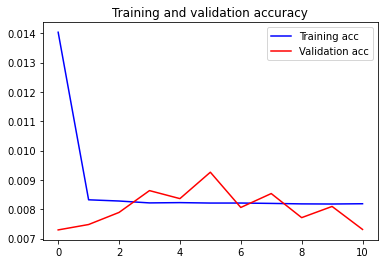

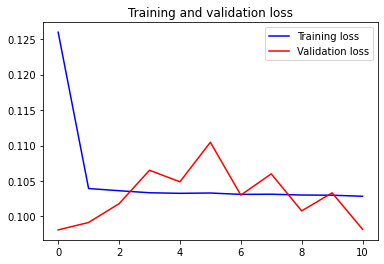

269/269 [==============================] - 3s 9ms/step


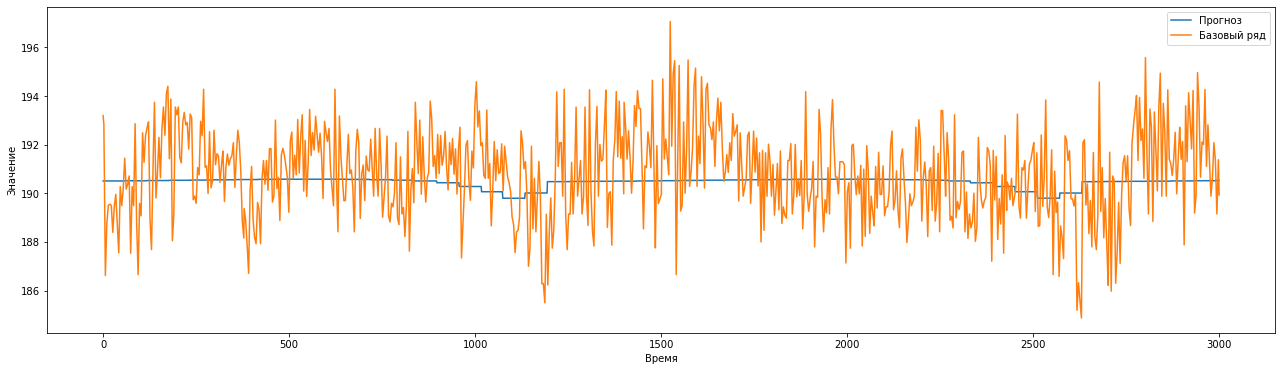

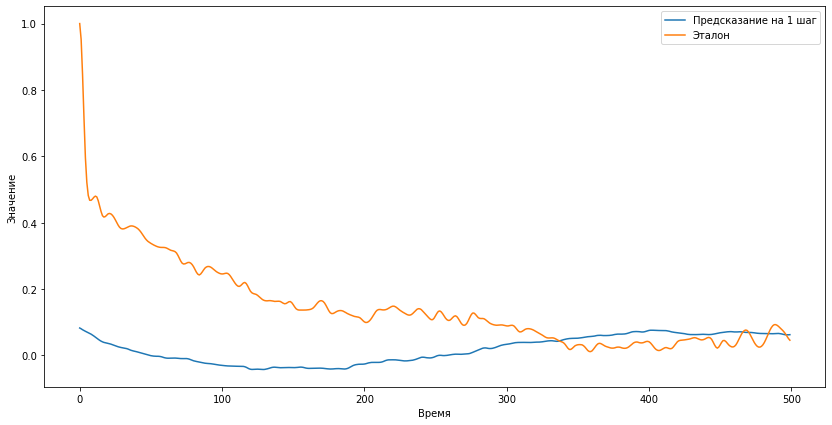

In [269]:
get_inf(modelL, 3000, 500)

## Conv new batch

In [80]:
callbacks_list = create_call('model_1C')
model_C1 = conv_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 105, 64)           384       
                                                                 
 conv1d_3 (Conv1D)           (None, 101, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               320100    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                      

In [81]:
# обучение модели при увеличенном батч batch_size с 1 до 5

history = model_C1.fit(
        X, y, epochs=50, batch_size=5, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
1458/1463 [============================>.] - ETA: 0s - loss: 0.0978 - log_cosh: 0.0077
Epoch 00001: val_log_cosh improved from inf to 0.00627, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1C
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1C\assets
1463/1463 [==============================] - 12s 8ms/step - loss: 0.0978 - log_cosh: 0.0077 - val_loss: 0.0906 - val_log_cosh: 0.0063
Epoch 2/50
1457/1463 [============================>.] - ETA: 0s - loss: 0.0890 - log_cosh: 0.0062
Epoch 00002: val_log_cosh did not improve from 0.00627
1463/1463 [==============================] - 11s 8ms/step - loss: 0.0890 - log_cosh: 0.0062 - val_loss: 0.1187 - val_log_cosh: 0.0108
Epoch 3/50
1462/1463 [============================>.] - ETA: 0s - loss: 0.0851 - log_cosh: 0.0058
Epoch 00003: val_log_cosh did not improve from 0.00627
1463/1463 [=========

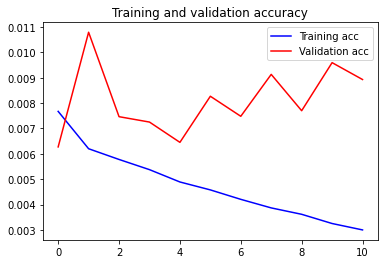

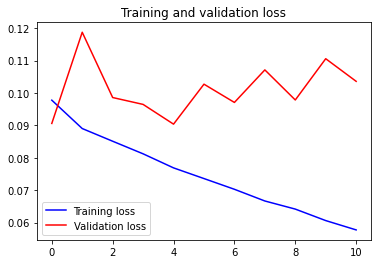

269/269 [==============================] - 1s 5ms/step


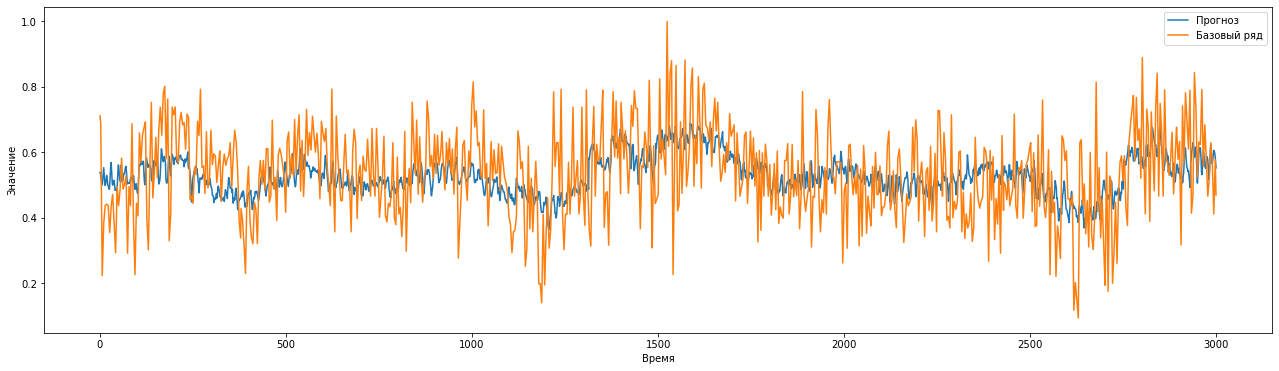

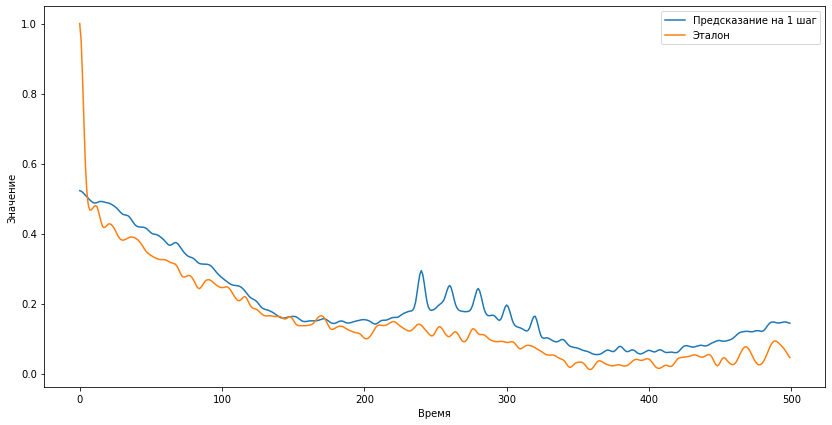

In [82]:
get_inf(model_C1, 3000, 500)

### Результат хуже, чем при меньшем batch size, но обучение идёт быстрее

## Conv new kernel_size

In [86]:
def conv_model():

    modelC = Sequential()

    modelC.add(Conv1D(64, 10, input_shape = input_shape_conv, activation="relu"))
    modelC.add(Conv1D(64, 10, activation="relu"))
    modelC.add(MaxPooling1D())
    modelC.add(Flatten())
    modelC.add(Dense(100, activation="relu"))
    modelC.add(Dense(1, activation="linear"))

    # компиляция модели

    modelC.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    modelC.summary()
    
    return modelC



In [87]:
callbacks_list = create_call('model_1C')
model_C2 = conv_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 100, 64)           704       
                                                                 
 conv1d_7 (Conv1D)           (None, 91, 64)            41024     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 45, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2880)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               288100    
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                      

In [88]:
# обучение модели при увеличенном батч batch_size с 1 до 5

history = model_C2.fit(
        X, y, epochs=50, batch_size=5, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
1460/1463 [============================>.] - ETA: 0s - loss: 0.0992 - log_cosh: 0.0078
Epoch 00001: val_log_cosh improved from inf to 0.00704, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1C
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_1C\assets
1463/1463 [==============================] - 16s 10ms/step - loss: 0.0992 - log_cosh: 0.0078 - val_loss: 0.0973 - val_log_cosh: 0.0070
Epoch 2/50
1462/1463 [============================>.] - ETA: 0s - loss: 0.0889 - log_cosh: 0.0062
Epoch 00002: val_log_cosh did not improve from 0.00704
1463/1463 [==============================] - 14s 10ms/step - loss: 0.0889 - log_cosh: 0.0062 - val_loss: 0.1021 - val_log_cosh: 0.0081
Epoch 3/50
1461/1463 [============================>.] - ETA: 0s - loss: 0.0838 - log_cosh: 0.0057
Epoch 00003: val_log_cosh did not improve from 0.00704
1463/1463 [=======

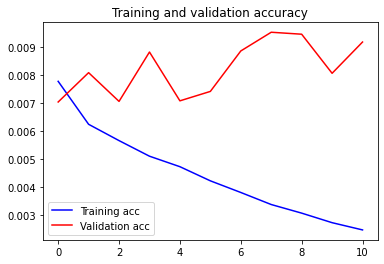

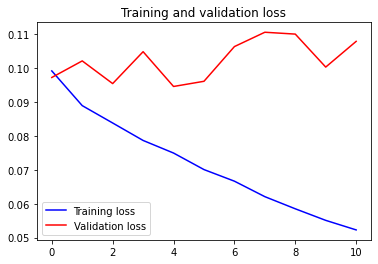

269/269 [==============================] - 2s 5ms/step


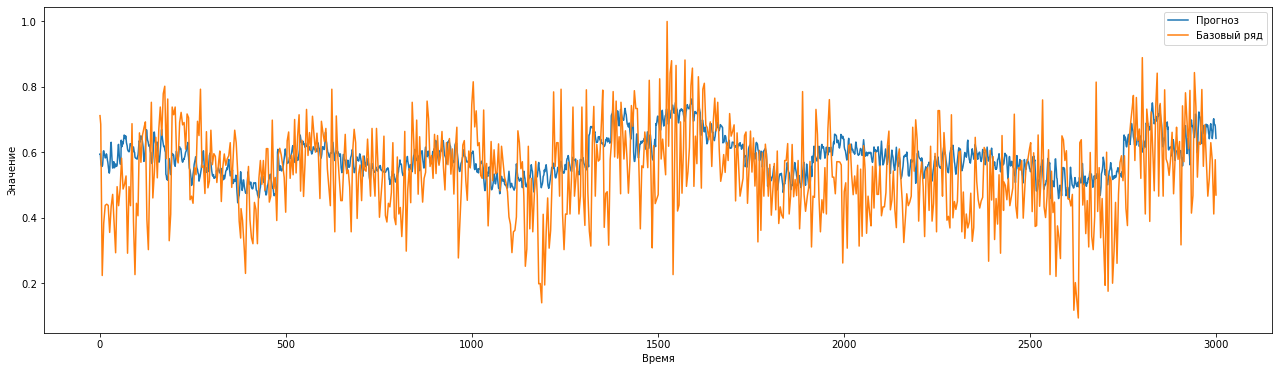

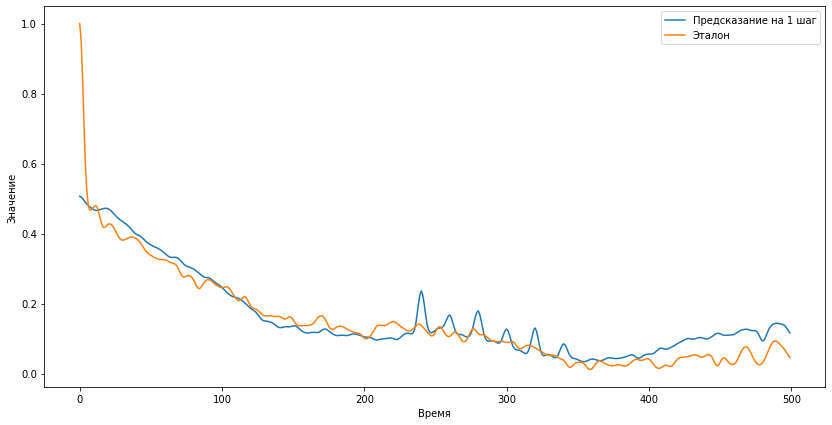

In [89]:
get_inf(model_C2, 3000, 500)

### Результат хуже, чем при меньшем kernel_size, но обучение идёт быстрее

## Контрольное обучение на 105тыс

In [232]:
def conv_model():

    modelC = Sequential()

    modelC.add(Conv1D(64, 5, input_shape = input_shape_conv, activation="relu"))
    modelC.add(Conv1D(64, 5, activation="relu"))
    modelC.add(MaxPooling1D())
    modelC.add(Flatten())
    modelC.add(Dense(100, activation="relu"))
    modelC.add(Dense(1, activation="linear"))

    # компиляция модели

    modelC.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    modelC.summary()
    
    return modelC



In [233]:
callbacks_list = create_call('model_final_C')
model_final_C = conv_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 105, 64)           384       
                                                                 
 conv1d_9 (Conv1D)           (None, 101, 64)           20544     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3200)              0         
                                                                 
 dense_8 (Dense)             (None, 100)               320100    
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                      

In [234]:
# обучение модели 

history = model_final_C.fit(
        X, y, epochs=50, batch_size=1, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
87819/87822 [============================>.] - ETA: 0s - loss: 0.0553 - log_cosh: 0.0024
Epoch 00001: val_log_cosh improved from inf to 0.00426, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_final_C
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_final_C\assets
87822/87822 [==============================] - 382s 4ms/step - loss: 0.0552 - log_cosh: 0.0024 - val_loss: 0.0707 - val_log_cosh: 0.0043
Epoch 2/50
87820/87822 [============================>.] - ETA: 0s - loss: 0.0521 - log_cosh: 0.0022
Epoch 00002: val_log_cosh improved from 0.00426 to 0.00313, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_final_C
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\model_final_C\assets
87822/87822 [==========

In [273]:
# создание и сохранение прогноза в форме датафрейма в csv
Time_Value_prognos=Test_sub['Data_Time_Prognoz'].values
predictions[:,0]
submission = pd.DataFrame({'TimeValue':Time_Value_prognos, 'Value':predictions[:,0]}, columns=['TimeValue', 'Value'])
submission.to_csv('submission.csv')  # был изначально файл submission2 

In [237]:
Test_m = conv_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 105, 64)           384       
                                                                 
 conv1d_11 (Conv1D)          (None, 101, 64)           20544     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 3200)              0         
                                                                 
 dense_10 (Dense)            (None, 100)               320100    
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                      

In [238]:
Test_m.load_weights(path + 'model_final_C.hdf5')

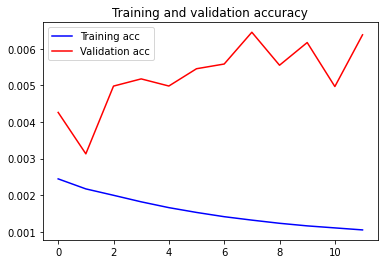

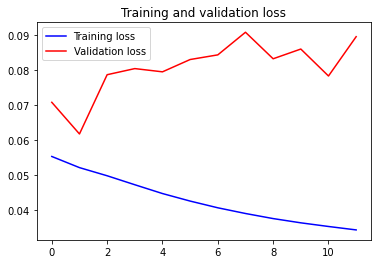

3229/3229 [==============================] - 14s 4ms/step


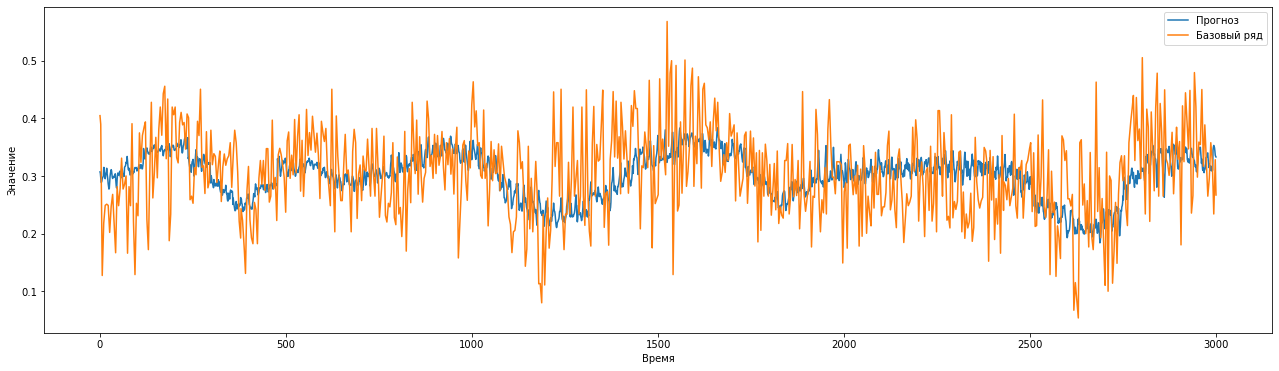

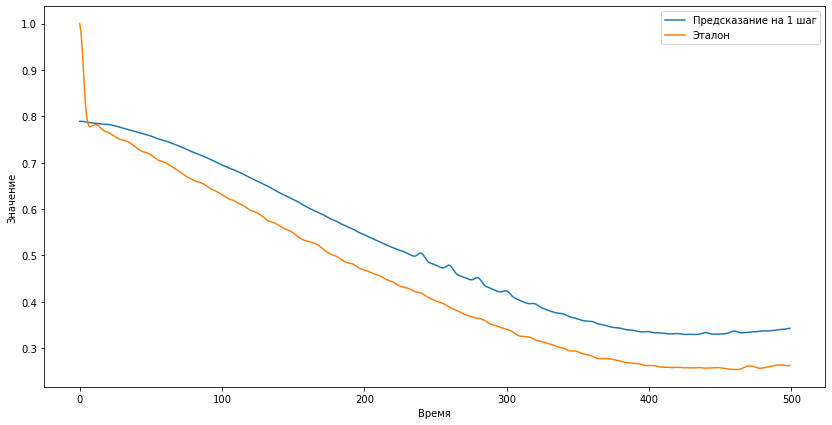

In [239]:
get_inf(model_final_C, 3000, 500)

## Была идея осуществлять подготовку данных с помощью генераторов, но тогда не берутся в учёт Dummy параметры, которые по условию важны

In [ ]:
train = res_v[:8000]
test = res_v[8000:]

In [ ]:
#data_len = 2879

window = 1441
y_index_start = 239
rate = 20
step = 1
batch = 1


data_len = train.shape[0]
y_len = data_len - 1680
x_index_end = window + y_len

x_train = train[:x_index_end] # Создаем x_train
y_train = train[y_index_start:] # Создаем y_train

# Создаем генератор
train_gen = TimeseriesGenerator(
    x_train,        # данные в x_train
    y_train,        # данные в y_train
    length= window,     # длина окна
    sampling_rate=rate,# указывает интервал значений в выборке, мне нужно 20!!!
    stride=step,       # шаг окна, равен 1 (но могу взять и другой, т.е. больше)
    batch_size=batch, end_index = x_index_end - 1    # batch_size для подачи в нейронку
    )

data_len = test.shape[0]
y_len = data_len - 1680
x_index_end = window + y_len

x_test = test[:x_index_end] # Создаем x_train
y_test = test[y_index_start:] # Создаем y_train

# Создаем генератор
test_gen = TimeseriesGenerator(
    x_test,        # данные в x_train
    y_test,        # данные в y_train
    length= window,     # длина окна
    sampling_rate=rate,# указывает интервал значений в выборке, мне нужно 20!!!
    stride=step,       # шаг окна, равен 1 (но могу взять и другой, т.е. больше)
    batch_size=batch, end_index = x_index_end -1   # batch_size для подачи в нейронку
    )